@ C. Giuppone . Reduccion de datos para detectar binarias . 26/5/2020. $corregido 2/6$

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import rebound
from math import *    #importa todas las operaciones matemáticas de math (sin, cos, tan, sqrt, pi, etc)

In [2]:
#anomalía eccéntrica
def ae(e,M):
    E = M #Valor inicial para iteración
    i = 0
    while True:
        E0 = E
        E = M + e*np.sin(E0)
        i = i+1
        D = (E-E0).astype('float')
        if (abs(D)<0.0001):
            return E
            break
#Anomalía verdadera:  Tan(F/2) = ee*Tan(E/2) #giuppone
def F(e,M):
    ee=np.sqrt((1+e)/(1-e))
    
    ss = sqrt(1. + e)*sin(ae(e,M)/2.)
    cs = sqrt(1. - e)*cos(ae(e,M)/2.)
    F   = 2*atan2(ss,cs)   #anomalía verdadera en cuadrante correcto
    return F            

Constantes

In [3]:
# https://www.iau.org/public/themes/measuring/ 
uam     = 1.495978707e11
c       = 2.99792458e8/uam #m/s/uam == ua/s
twopi   = pi*2
dy     = 365.25
k      = 1.720209895e-02
mearth = 3.04043e-6       # earth mass in solar masses
mjup   = 9.54792e-4       #pup in solar masses
rad    = twopi/360.0

In [4]:
F(0.1,100*rad)/rad

110.97786295129742

DATOS

In [5]:
m0=0.78
m1=0.43

eb=0.
pb=0.1507574  #days  #Porb;bin = 3:168 horas (O'Donoghue et al. 2003).

mp=52.7*mjup  #0.05033
pp=18.96   #years
ep=0.95
w = 206*rad
T0 =2453831. 
Me = m0+m1

Resultados   a= (P/2pi)^2 (k^2*(M0+M1) ) 

In [6]:
# semieje del planeta alrededor de la orbita relativa
arel  = ((18.96*365.25/(twopi))**2*k*k*(mp+0.78+0.43))**(1./3.)
#ap    = ((18.96*365.25/(twopi))**2*k*k*(0.0+0.78+0.43))**(1./3.)

ab = ((0.1507574/(twopi))**2*k*k*(0.78+0.43))**(1./3.)

#calcular las órbitas para tiempo 120 dias después del pasaje por el pericentro. #JD
t  = 2453831.+120
n  = twopi/(pp*dy)
M  = n*(t-T0)
inc0 = 76*rad   # Latković
print (ab,arel,mp)

0.005907203488090955 7.680333532161486 0.0503175384


Dibujar juntos los datos de los tiempos de tránsito de QS-vir

In [7]:
data =np.loadtxt('qsvir.dat',usecols=(1,2,3))
t = data[:,0]   #time
ti   = t[0]
tr   = t-t[0]  #gave time with respect to first observation
taur  = data[:,1]
etaur = data[:,2]

[1.50757506e-01 4.86896404e+04]


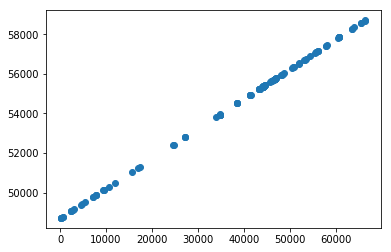

In [11]:
x = np.loadtxt('qsvir.dat',usecols=(0)) 
y = np.loadtxt('qsvir.dat',usecols=(1)) 
model = np.polyfit(x, y, 1)

plt.scatter(x,y)
print (model)


In [12]:
predict = np.poly1d(model)

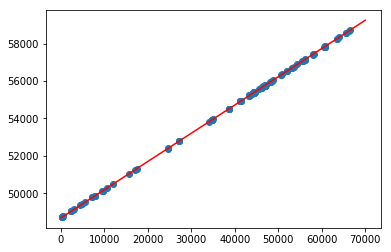

In [13]:
x_lin_reg = range(0, 70000)
y_lin_reg = predict(x_lin_reg)
plt.scatter(x, y)
plt.plot(x_lin_reg, y_lin_reg, c = 'r')


In [ ]:

yi = predict()


In [22]:
def tau(ainc,e,w,t0,z0,P,t):  #P in years #z0 in secs
    P = P*365.25
    n = 2*pi/P
#    a = (G*(Mp+Me)/n**2)**(1./3.)
    M  = n*(t-t0)
    f  = F(e,M)
    
    Mp=mp

#     r     = a*(1-e**2)/(1+e*cos(f))
#     zrel  = r*sin(inc)*sin(w+f)+z0
#     zab   zrel*Mp/(Me+Mp)
#    z  =a*(1-e**2)/(1+e*cos(f))*sin(inc)*sin(f+w)+z0   #r*sin(inc)*sin(w+f)+z0
    z  = ainc*Mp/(Me+Mp)*(1-e**2)/(1+e*cos(f))*sin(f+w) 
    print (f,M,z)
    tau=z/c+z0
    return tau

Dibujar ambas curvas

In [23]:
test1 = (7, 0.9, 1, 57000, 0, 18)  
print (tau(7, 0.9, 1, 57000, 0, 18, 58000))


2.7909036540848917 0.9556902132754713 -0.20743345235469338
-103.51028505264141


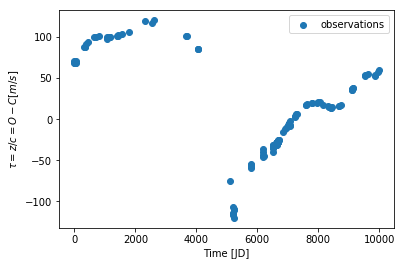

In [10]:
#plt.scatter(times,z[1]/c*mp/(m0+m1+mp), label='n-body')
plt.scatter(tr,taur, label='observations')
#plt.plot(times*1.3,(z[1]/c*mp/(m0+m1+mp))*1.5-90, label='n-body corrected')
#plt.xlim(0,7000)
plt.xlabel('Time [JD]')
#plt.ylim(-30,141)
plt.ylabel(r'$\tau=z/c = O-C [m/s]$')
plt.legend()
plt.show()


In [11]:
#Construct syntethic curves
def synt(Params):    #genera una curva de "z" con params
    ainc,e,w,t0,z0,P = Params
    Zsy =[]   #velocidad radial sintética (genero una curva continua sin errores)
    Tsy =[]
    nf=1000
    delta=max(t)-min(t)
    ij=0
#    print (min(t),delta)
    while ij < nf:
        tsy=min(t)+delta*ij/nf
        Zsy.append(tau(ainc,e,w,t0,z0,P,tsy))
        Tsy.append(tsy)
        ij = ij+1
#        print (tsy,ij)       
    return Tsy,Zsy   

def OC(Params):    #genera una curva de velocidad radial con params
    ainc,e,w,t0,z0,P = Params
    BOC   =[]
    TOC   =[] 
    ij=0
    while ij < len(t):
        BOC.append(tau(ainc,e,w,t0,z0,P,t=t[ij]))
        TOC.append(t[ij])
        ij = ij+1
    return TOC,BOC    

In [12]:
#Generate synt
m0=0.78
m1=0.43
Me=m0+m1

Mp=52.7*mjup  #0.05033
pp=18.96   #years
ainc = 7.1 #au
ep=0.95
w = 206*rad
T0 =2453831-(2400000)
z0 = 0. 
print(T0,t[0],min(t))

53831 48715.419887605 48715.419887605


In [13]:
#ainc,e,w,t0,z0,P 
Params = ainc,ep,w,T0,z0,pp
tsy0,zsy0 = synt(Params)
Params = ainc,ep,w,57000.,z0,pp
tsy1,zsy1 = synt(Params)
Params = ainc,ep,w,T0,-10,pp
tsy2,zsy2 = synt(Params)


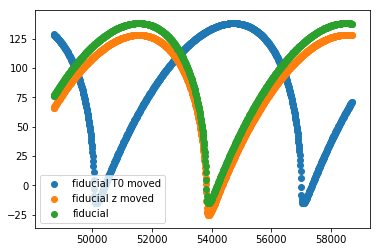

In [14]:
#the amplitude does not change with T0
plt.scatter(tsy1,zsy1, label='fiducial T0 moved')
plt.scatter(tsy2,zsy2, label='fiducial z moved')
plt.scatter(tsy0,zsy0, label='fiducial')
plt.legend()

Maximal amplitude of TVE signal (see Woltjer 1922) <br>
$z1-z2=a sin(inc) sin (u1)=a \sin(inc) \sqrt{1-e^2 cos^2(w)}$

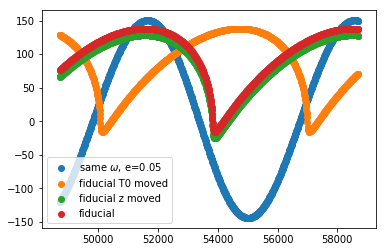

In [15]:
#comparar con las mismas masas y ainc, pero cambiando a la región con mayor amplitud (e~0, w=206).
# con esto nos damos cuenta cual es la región de maxima amplitud.
#major amplitude
Params = ainc,0.05,206*rad,T0,0.,pp
tsy3,zsy3 = synt(Params)
plt.scatter(tsy3,zsy3, label=r'same $\omega$, e=0.05')
plt.scatter(tsy1,zsy1, label='fiducial T0 moved')
plt.scatter(tsy2,zsy2, label='fiducial z moved')
plt.scatter(tsy0,zsy0, label='fiducial')
plt.legend()

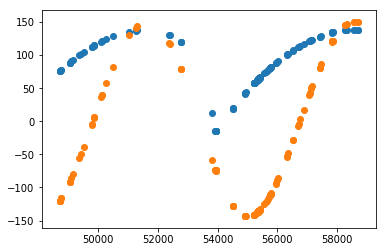

In [16]:
Params = ainc,0.95,206*rad,T0,0.,pp
toc0,zoc0  = OC(Params)
Params = ainc,0.05,206*rad,T0,0.,pp
toc1,zoc1  = OC(Params)
plt.scatter(toc0,zoc0)
plt.scatter(toc1,zoc1)

In [17]:
#Defino una WRMS que dependa de una sóla variable (que será un arreglo) (así funciona el minimizador)
#Los DATOS que tengo son: t, taur, etaur
#P e t0 w mp v0 = Params
#bounds = ((aincm,aincmax), (emin,emax), (wmin, wmax), (t0min,t0max), (z0min,z0max), (Pmin,Pmax))
def WRMS(Params):

#    print (Params)
#    print (bounds)
    for x,r in zip(Params,bounds):    #el comando junta los datos de Params y bounds
        if x < r[0] or x > r[1]:      #si los params son mayores o menores q los bounds retorna infinito 
      #      print (x,r[0],r[1])
            return np.inf
        
    ainc,e,w,t0,z0,P = Params    #Arreglo a minimizar
    Be=taur
     
#    print(taur[0:2],t[0:2])
    VT=[]
    ij = 0
    while ij<len(Be):
        VT.append(tau(ainc,e,w,t0,z0,P,t=t[ij]))
        ij = ij + 1
        
    N =len(Be)
    err   = etaur #np.sqrt(ei**2+sj**2)
    invS  =np.sum(1./err**2)
    Ab    =invS/N/(N-1.)

    WRMS=Ab*np.sum((( VT - Be)/err)**2.)
    return np.sqrt(WRMS)  

def nWRMS(Params):
    wi=WRMS(Params)
    N =len(taur)
    w2=wi*N*(N-1)
    return -0.5*w2

In [18]:
(max(t)-min(t))/365.25,max(t)-min(t)

(27.353871233722106, 9991.001468117)

In [33]:
Params = ainc,0.95,206*rad,T0,0.,pp
# bounds = ((aincm,aincmax), (emin,emax), (wmin, wmax), (t0min,t0max), (z0min,z0max), (Pmin,Pmax))
Pmin=(t[2]-t[0])/dy
Pmax=(max(t)-min(t))/dy   #in years
t0min = min(t)
t0max = max(t)
z0min = min(taur)
z0max = max(taur)
aincmin = ((Pmin*dy/(twopi))**2*k*k*(Me))**(1./3.)
aincmax = ((Pmax*dy/(twopi))**2*k*k*(Me))**(1./3.)
bounds = (aincmin,aincmax), (0,0.99), (0, 2*pi), (t0min,t0max), (z0min,z0max), (Pmin,Pmax)
bounds = (aincmin,aincmax), (0,0.99), (0, 2*pi), (t0min,t0max), (z0min,z0max), (15.,28.)
WRMS(Params)

949.8398899642008

In [18]:
# %%time
# import scipy.optimize as optimize
# #Minimize # genetics algorithm. No necesita condicion inicial...sólo bounds!
# resultga0 = optimize.differential_evolution(WRMS, bounds, strategy='best1bin', maxiter=120, popsize=100,tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=True, polish=True, init='latinhypercube', atol=0)   #disp=True si queremos ver como avanza.
# resultga0.x

In [19]:
# print(*Params)
# print(*resultga0.x)
# print(bounds)   #mi resultado está dando muy cerca de los BOUNDS. Repetir.
# f = open("fits.txt", "w")
# print(resultga0.fun,resultga0.x[2]/rad)
# print ("P ","ainc ", "ainc e w T0 z  P ", "WRMS ","\n",file=f, end=' ', sep=' ')
# print (resultga0.x[4],resultga0.x[0],*resultga0.x,resultga0.fun,"\n",file=f, end=' ', sep=' ')
# f.close()
# print (*resultga0.x)

82.67461312489762 106.76369761113692


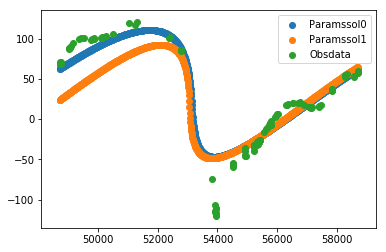

In [35]:
#Paramssol = ainc,e,w,T0,z,P
Paramssol0 = (9.02724903e+00, 9.11372213e-01, 3.23027678e+00, 5.31457517e+04, 1.68270052e+01, 2.73368237e+01)
Paramssol1 = (9.38302959e+00, 9.32856790e-01, 3.17089423e+00, 5.30599905e+04, 1.66289206e+01, 2.29992555e+01)
# tga,tauga   = synt(resultga0.x)
tga,tauga   = synt(Paramssol0)
tga1,tauga1 = synt(Paramssol1)
plt.scatter(tga,tauga, label="Paramssol0")
plt.scatter(tga1,tauga1, label="Paramssol1")
plt.scatter(t,taur, label="Obsdata")

plt.legend()
print (WRMS(Paramssol0),WRMS(Paramssol1))

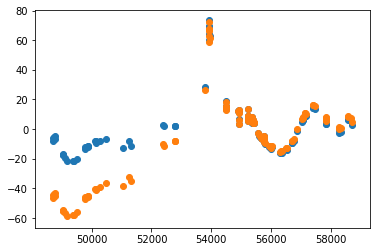

In [38]:
toc0,zoc0  = OC(Paramssol0)
toc1,zoc1  = OC(Paramssol1)
plt.scatter(toc0,zoc0-taur, label="Paramssol0")
plt.scatter(toc1,zoc1-taur, label="Paramssol1")

In [41]:
#Paramssol = ainc,e,w,T0,z,P
Paramssol0 = (9.02724903e+00, 9.11372213e-01, 3.23027678e+00, 5.31457517e+04, 1.68270052e+01, 2.73368237e+01)
a=9.02724903e+00/sin(76*rad)
print (a*sin(76*rad),a)

mtot = mstar
do i = 1,npla
mtot = mtot + mass(i)
end do
do i = 1,npla
deno = (k2*(mstar+mass(i)))**0.33333333
mass(i) = massf(i)*mtot/deno/sin(inc(i))
end do
end do
do i = 1,npla
semi(i) = (k2*(mstar+mass(i))/ene(i)/ene(i))**0.333333333
end do

9.02724903 9.303605885853647


In [24]:
%%time
ntotg=20
asi  = 7.1 # 76^o 7.58
#x0=resultga0.x # Param0    #Param0 = (ainc, e, w, t0, z0, P)   #parámetros iniciales
#f = open("output2.txt", "w")   #write format (w) to file output.txt
resultsim = resultga0

print (*resultga0.x)
print (*resultsim.x)
for ik in range(0,ntotg+1,1):
        P    =15.5+ik*(5.5)/ntotg
        a    = ((P*dy/(twopi))**2*k*k*(0.78+0.43))**(1./3.)
        ainc = a*sin(76*rad) 
        bounds1 = (ainc*0.9,ainc*1.1), (0.7,0.99), (0, 2*pi), (t0min,t0min+P*dy), (z0min,z0max), (0.9999*P,1.0001*P)
        resultga01 = optimize.differential_evolution(WRMS, bounds1, strategy='best1bin', maxiter=40, popsize=50,tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=True, polish=True, init='latinhypercube', atol=0)   #disp=True si queremos ver como avanza.
#        resultsim  = optimize.minimize(WRMS, resultsim.x, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
        Params = ainc,0.95,206*rad,T0,0.,P  
        print (P,a,*resultga01.x,resultga01.fun,ik, "\n",file=f, end=' ', sep=' ')
#        print (P,a,*resultsim.x,resultsim.fun,"\n",file=f, end=' ', sep=' ')
        print (P,a,resultga01.fun,WRMS(Params),ik,"\n",sep=' ')
        f.flush()
f.close()


9.38302958983434 0.9328567895621869 3.170894228155362 53059.99046113527 16.628920550606182 22.999255526917317
9.38302958983434 0.9328567895621869 3.170894228155362 53059.99046113527 16.628920550606182 22.999255526917317
differential_evolution step 1: f(x)= 206.803
differential_evolution step 2: f(x)= 206.803
differential_evolution step 3: f(x)= 206.803
differential_evolution step 4: f(x)= 196.751
differential_evolution step 5: f(x)= 196.654
differential_evolution step 6: f(x)= 190.759
differential_evolution step 7: f(x)= 190.759
differential_evolution step 8: f(x)= 190.759
differential_evolution step 9: f(x)= 190.759
differential_evolution step 10: f(x)= 190.664
differential_evolution step 11: f(x)= 190.267
differential_evolution step 12: f(x)= 190.267
differential_evolution step 13: f(x)= 187.915
differential_evolution step 14: f(x)= 187.435
differential_evolution step 15: f(x)= 187.435
differential_evolution step 16: f(x)= 187.435
differential_evolution step 17: f(x)= 187.115
differe

In [32]:
resultga0.x

array([9.40855868e+00, 9.28288350e-01, 3.16134493e+00, 5.30595231e+04,
       2.09722032e+01, 2.29963201e+01])

In [25]:
#resultsim = optimize.minimize(WRMS, resultga0.x, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
resultsim.x
#print (Pmax, (max(t)-min(t))/dy)

array([9.38302959e+00, 9.32856790e-01, 3.17089423e+00, 5.30599905e+04,
       1.66289206e+01, 2.29992555e+01])

In [26]:
print (*resultsim.x,resultsim.fun)
print (*resultga0.x,resultga0.fun)

9.38302958983434 0.9328567895621869 3.170894228155362 53059.99046113527 16.628920550606182 22.999255526917317 106.76369739445624
9.38302958983434 0.9328567895621869 3.170894228155362 53059.99046113527 16.628920550606182 22.999255526917317 106.76369739445624


In [4]:
plt.scatter(t,taur)

NameError: name 'plt' is not defined

Finding optimal frequency:
 - Estimated peak width = 0.000629
 - Using 5 steps per peak; omega_step = 0.000126
 - User-specified period range:  3.6e+02 to 9.1e+03
 - Computing periods at 133 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


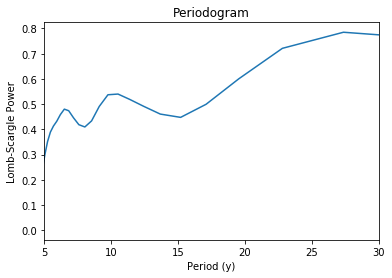

In [56]:
#Periodograma
from gatspy.periodic import LombScargleFast
from gatspy import datasets, periodic #Importo "periodic" para definir el modelo

model = periodic.LombScargleFast(fit_period=True) #Defino modelo
model.optimizer.period_range = (1.*365.25, 25.*365.25)        #Rango para buscar períodos
model.fit(t, taur, etaur)                         #Ingreso mis datos al modelo y ajusto
periods3, power3 = model.periodogram_auto()     #Obtengo resultados

#Grafico:
fig, ax = plt.subplots()
ax.plot(periods3/365.25, power3)
plt.title('Periodogram')
ax.set(xlim=(5, 30), xlabel='Period (y)', ylabel='Lomb-Scargle Power');

In [3]:
print(t[0:10],tau[0:10])


NameError: name 't' is not defined